In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import tensorflow as tf
from keras import layers
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import  Dropout, Reshape
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.models import Model
from keras.initializers import glorot_uniform

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
y_test_ = y_test
print("Train Set Size = {} images".format(y_train.shape[0]))
print("Test Set Size = {} images".format(y_test.shape[0]))
print(x_train.shape)
print(x_test.shape)

Train Set Size = 60000 images
Test Set Size = 10000 images
(60000, 28, 28)
(10000, 28, 28)


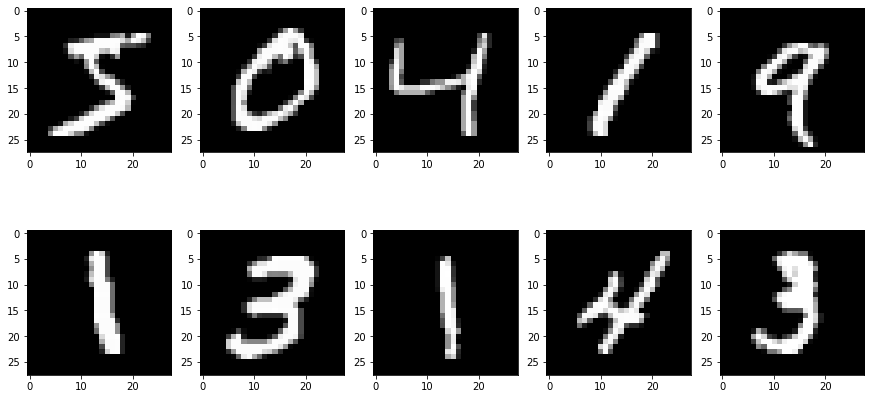

Labels : [5 0 4 1 9]
Labels : [1 3 1 4 3]


In [4]:
fig1 = plt.figure(figsize = (15,15))

for i in range(5):
    ax1 = fig1.add_subplot(1,5,i+1) 
    ax1.imshow(x_train[i], interpolation='none', cmap=plt.cm.gray)
    ax2 = fig1.add_subplot(2,5,i+6) 
    ax2.imshow(x_train[i+6], interpolation='none', cmap=plt.cm.gray)
plt.show()

print("Labels : {}".format(y_train[0:5]))
print("Labels : {}".format(y_train[6:11]))

In [5]:
print(x_train.shape)
print(x_test.shape)

# expand new axis, channel axis 
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# it's always better to normalize 
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


# resize the input shape , i.e. old shape: 28, new shape: 32
x_train = tf.image.resize(x_train, [32,32]) # if we want to resize 
x_test = tf.image.resize(x_test, [32,32]) # if we want to resize 

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000, 32, 32, 1)
(10000, 32, 32, 1)


In [6]:
def reshaping(x):
  return np.reshape(x,(32,32))

a = list((map(reshaping,x_train)))
x_train = np.array(a)

b = list((map(reshaping,x_test)))
x_test = np.array(b)

print(x_train.shape)
print(x_test.shape)


(60000, 32, 32)
(10000, 32, 32)


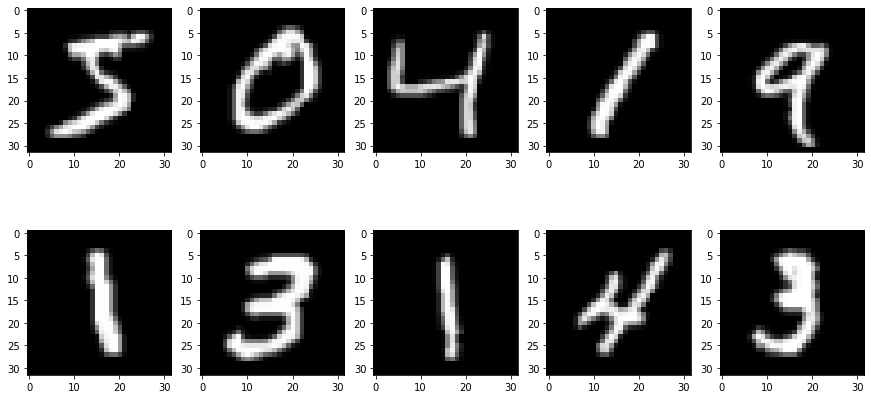

Labels : [5 0 4 1 9]
Labels : [1 3 1 4 3]


In [7]:
fig1 = plt.figure(figsize = (15,15))

for i in range(5):
    ax1 = fig1.add_subplot(1,5,i+1) 
    ax1.imshow(x_train[i], interpolation='none', cmap=plt.cm.gray)
    ax2 = fig1.add_subplot(2,5,i+6) 
    ax2.imshow(x_train[i+6], interpolation='none', cmap=plt.cm.gray)
plt.show()

print("Labels : {}".format(y_train[0:5]))
print("Labels : {}".format(y_train[6:11]))

In [8]:
from  keras.utils import np_utils
y_train = to_categorical(y_train, num_classes=10, dtype='float32')
y_test = to_categorical(y_test, num_classes=10, dtype='float32')

print("Train Set Size = {} images".format(y_train.shape[0]))
print("Test Set Size = {} images".format(y_test.shape[0]))

Train Set Size = 60000 images
Test Set Size = 10000 images


In [9]:
optimizer = 'adam'
objective = 'categorical_crossentropy'

def identity_block(X, f, filters, stage, block):
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(1,1), padding='valid', name=conv_name_base+'2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding='same', name=conv_name_base+'2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding='valid', name=conv_name_base+'2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2c')(X)

    X = layers.Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def convolutional_block(X, f, filters, stage, block, s=2):
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(s,s), name=conv_name_base+'2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding='same', name=conv_name_base+'2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), name=conv_name_base+'2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2c')(X)

    X_shortcut = Conv2D(F3, kernel_size=(1,1), strides=(s,s), name=conv_name_base+'1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base+'1')(X_shortcut)

    X = layers.Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


def resNet():
    
    # Define the input as a tensor with shape input_shape
    X_input = Input((32,32,1))
    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1',)(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    
    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    '''
    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    
    '''

    # AVGPOOL
    X = AveragePooling2D((2,2), name='avg_pool')(X)
    
    # output layer
    X = Dropout(rate=.2)(X)
    X = Flatten()(X)
    X = Dropout(rate=.5)(X)

    X = Dense(2048, activation='relu', name='fc1')(X)
    X = Dropout(rate=.2)(X)
    X = Dense(1024, activation='relu', name='fc2')(X)
    X = Dropout(rate=.2)(X)

    X = Dense(y_train.shape[1], activation='softmax', name='predictions' + str(y_train.shape[1]))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')
    
    #Compile the model
    model.compile(optimizer=optimizer, loss=objective, metrics=['accuracy'])
    
    return model

In [10]:
model = resNet()
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 38, 38, 1)   0           ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 16, 16, 64)   3200        ['zero_padding2d[0][0]']         
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1[0][0]']                  
                                                                                           

In [11]:
batch_size = 64
num_epoch = 200

# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('/content/drive/MyDrive/model/resnet_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

#model training
ret = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=num_epoch,
          verbose=1,
          #validation_split=0.25,
          validation_data=(x_test, y_test),
          callbacks=[es, mc])

Epoch 1/200
938/938 [==============================] - ETA: 0s - loss: 0.3131 - accuracy: 0.9229

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


938/938 [==============================] - 49s 47ms/step - loss: 0.3131 - accuracy: 0.9229 - val_loss: 0.1100 - val_accuracy: 0.9763
Epoch 2/200
938/938 [==============================] - 44s 47ms/step - loss: 0.0797 - accuracy: 0.9803 - val_loss: 0.0488 - val_accuracy: 0.9865
Epoch 3/200
938/938 [==============================] - 44s 46ms/step - loss: 0.0728 - accuracy: 0.9824 - val_loss: 0.0750 - val_accuracy: 0.9812
Epoch 4/200
938/938 [==============================] - 42s 45ms/step - loss: 0.0613 - accuracy: 0.9856 - val_loss: 0.1153 - val_accuracy: 0.9706
Epoch 5/200
938/938 [==============================] - 44s 47ms/step - loss: 0.0590 - accuracy: 0.9860 - val_loss: 0.0432 - val_accuracy: 0.9896
Epoch 6/200
938/938 [==============================] - 42s 45ms/step - loss: 0.0528 - accuracy: 0.9874 - val_loss: 0.0539 - val_accuracy: 0.9868
Epoch 7/200
938/938 [==============================] - 44s 47ms/step - loss: 0.0535 - accuracy: 0.9876 - val_loss: 0.0336 - val_accuracy: 0.99

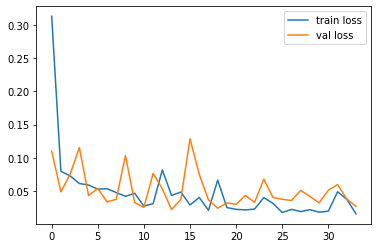

In [12]:
plt.plot(ret.history['loss'], label='train loss')
plt.plot(ret.history['val_loss'], label='val loss')
plt.legend()
plt.show()

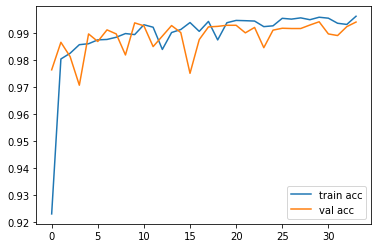

In [13]:
plt.plot(ret.history['accuracy'], label='train acc')
plt.plot(ret.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [14]:
# evaluate the model
_, train_acc = model.evaluate(x_train, y_train, verbose=0)
_, test_acc = model.evaluate(x_test, y_test, verbose=0)
print('Train accuracy: %.3f, Test accuracy: %.3f' % (train_acc, test_acc))

Train accuracy: 0.998, Test accuracy: 0.994


In [15]:
predictions = model.predict(x_test.reshape((-1,32,32,1)), verbose=0)

In [16]:
def test_accuracy():
    err = []
    t = 0
    for i in range(predictions.shape[0]):
        if (np.argmax(predictions[i]) == y_test_[i]):
            t = t+1
        else:
            err.append(i)
    return t, float(t)*100/predictions.shape[0], err

In [17]:
p = test_accuracy()
print("Test accuracy: {} %".format(p[1]))

Test accuracy: 99.4 %


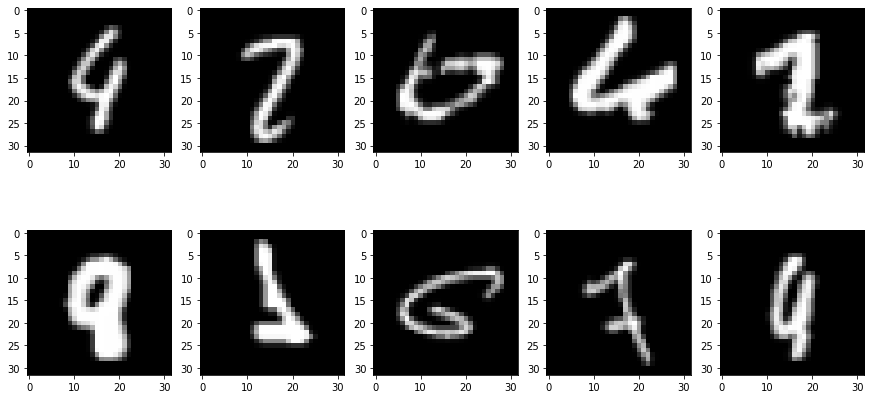

True:          [4 2 6 6 2]
classified as: [9 7 0 4 7]
True:          [8 1 6 7 9]
classified as: [9 5 0 1 4]


In [18]:
fig1 = plt.figure(figsize = (15,15))

for i in range(5):
    ax1 = fig1.add_subplot(1,5,i+1) 
    ax1.imshow(x_test[p[2][i]], interpolation='none', cmap=plt.cm.gray)
    ax2 = fig1.add_subplot(2,5,i+6) 
    ax2.imshow(x_test[p[2][i+6]], interpolation='none', cmap=plt.cm.gray)
plt.show()

print("True:          {}".format(y_test_[p[2][0:5]]))
print("classified as: {}".format(np.argmax(predictions[p[2][0:5]], axis=1)))

print("True:          {}".format(y_test_[p[2][6:11]]))
print("classified as: {}".format(np.argmax(predictions[p[2][6:11]], axis=1)))